In [1]:
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
from helper_code_qutip import *
from scipy import integrate
import scipy.io

In [2]:
def lamb_integrand(omega,E1,E2,alpha,beta,gamma1,gamma2,beta1,beta2,mu1,mu2,tb,flag): #this function computes the integrand of the lamb shift formula.
    term=0
    
    if (alpha <0 or beta<0):
        print('indices are wrong. ERror')
        return 0
    elif (alpha>4 or beta>4):
        print('indices are wrong. err0r')
        return 0
    #alpha, beta have to be between 1 and 4.
    elif (alpha <=2 and beta>=3): #we output zero
        return 0
    elif (alpha>=3 and beta <=2):
        return 0
    elif (alpha<=2 and beta<=2): #we are in the first bath setup
        term=term+gmatrix(omega-E1,gamma1,beta1,mu1,tb,alpha,1)*gmatrix(omega+E2,gamma1,beta1,mu1,tb,1,beta)
        term=term+gmatrix(omega-E1,gamma1,beta1,mu1,tb,alpha,2)*gmatrix(omega+E2,gamma1,beta1,mu1,tb,2,beta)
        if (flag==0):
            return term.real
        elif (flag==1):
            return term.imag
        else:
            print('flag invalid')
            return term
    elif (alpha >=3 and beta>=3):
        term=term+gmatrix(omega-E1,gamma2,beta2,mu2,tb,alpha-2,1)*gmatrix(omega+E2,gamma2,beta2,mu2,tb,1,beta-2)
        term=term+gmatrix(omega-E1,gamma2,beta2,mu2,tb,alpha-2,2)*gmatrix(omega+E2,gamma2,beta2,mu2,tb,2,beta-2)
        if (flag==0):
            return term.real
        elif (flag==1):
            return term.imag
        else:
            print('flag invalid')
            return term

In [2]:

        
Tc_list = [0.001,0.18,0.20]
Th_list = [0.4,0.7,1.0] #For some reason, integral diverges outside this range


betalist1 = [1/Tc for Tc in Tc_list]
betalist2 = [1/Th for Th in Th_list]

elist = np.linspace(0,0.05,20)

print(len(betalist1),len(betalist2))

redfield_ss = []
g = 1.6e-3
for beta2 in betalist2:
    list_red = []
    list_lle = []
    for e in elist:
        limit_value=700
        b=50
        N=2
        w0min=1
        w0max=w0min+e
        delta=1
        gmin=1.6e-3
        gmax=1.6e-3
        beta1 = 1/0.1  #Tc = 0.1
            
        w0list=np.linspace(w0min,w0max,N)
        glist=np.linspace(gmin,gmax,N-1)

        g = glist[0]
            
        tb=0.01
        epsilon=1
        gamma1=1e-3 #gamma1 is the coupling to left bath. It shows up in spectral bath function
        gamma2=1.1e-2   #gamma2 is the coupling to the right bath.    
            
            

        mu=0
            
            
        delta=1
        mu1=mu
        mu2=mu

        H_S=create_hamiltonian2(w0list,glist,N)
    
    
        c_N=create_sm(N,N)  # we couple the Nth spin to the bath
        c_1=create_sm(N,1)
        
        
        
        eigenergies,eigstates=H_S.eigenstates()
        
        #print("eigenenergies are : ",eigenergies)
        
        spectrum=max(eigenergies)-min(eigenergies)
        
        
        
        number=len(eigenergies)
        
        integral11=np.empty((number,number),dtype=np.cdouble) #stores J * N integral for left bath
        integral12=np.empty((number,number),dtype=np.cdouble) # stores J integral (just to check) for the left bath
        integral21=np.empty((number,number),dtype=np.cdouble) #stores J*N integral for right bath
        integral22=np.empty((number,number),dtype=np.cdouble)

        print("Integral calculations at beta2 = {} and e = {} are : ".format(beta2,e))

        for i in range(number):
            for k in range(number):
                freq=eigenergies[k]-eigenergies[i]
                print(f"Absolute frequency  for i = {i}, k = {k} is ",np.absolute(freq))
                #print(i,k,freq)
                if( np.absolute(freq) >= 1/10**10):
                    integral11[i,k]=(-1.0j/(2*np.pi))*integrate.quad(func1,0,b,args=(tb,beta2,mu2,gamma1),limit=limit_value,weight='cauchy',wvar=eigenergies[k]-eigenergies[i])[0] #func 1
                    integral12[i,k]=(-1.0j/(2*np.pi))*integrate.quad(spectral_bath,0,b,args=(tb,gamma1),limit=limit_value,weight='cauchy',wvar=eigenergies[k]-eigenergies[i])[0]  #left bath done
                    integral21[i,k]=(-1.0j/(2*np.pi))*integrate.quad(func1,0,b,args=(tb,beta1,mu1,gamma2),limit=limit_value,weight='cauchy',wvar=eigenergies[k]-eigenergies[i])[0] #func 1
                    integral22[i,k]=(-1.0j/(2*np.pi))*integrate.quad(spectral_bath,0,b,args=(tb,gamma2),limit=limit_value,weight='cauchy',wvar=eigenergies[k]-eigenergies[i])[0]  #right bath
        
                if (np.absolute(freq)<=1/10**10):  #The problem is arising here....
                    integral11[i,k]=(-1.0j/(2*np.pi))*integrate.quad(func2,0,np.inf,args=(tb,beta2,mu2,gamma1),limit=limit_value)[0]
                    integral12[i,k]=(-1.0j/(2*np.pi))*integrate.quad(spectral_bath_2,0,np.inf,args=(tb,gamma1),limit=limit_value)[0]
                    integral21[i,k]=(-1.0j/(2*np.pi))*integrate.quad(func2,0,np.inf,args=(tb,beta1,mu1,gamma2),limit=limit_value)[0]
                    integral22[i,k]=(-1.0j/(2*np.pi))*integrate.quad(spectral_bath_2,0,np.inf,args=(tb,gamma2),limit=limit_value)[0]
                
            
            #expected=1.0j*(eigenergies[k]-eigenergies[i])/(2*tb*tb)
        #        print(i,k,integral2[i,k],expected)
    
    
        # PAY ATTENTION TO THE WAY THESE COEFFICIENTS ARE BEING COMPUTED
    
        constant12=np.empty((number,number),dtype=np.cdouble)
        constant11=np.empty((number,number),dtype=np.cdouble)
        constant21=np.empty((number,number),dtype=np.cdouble)
        constant22=np.empty((number,number),dtype=np.cdouble)
        
        
        
        for i in range(number):
            for k in range(number):
                constant12[i,k]=integral12[i,k]+integral11[i,k]+0.5*(spectral_bath(eigenergies[k]-eigenergies[i],tb,gamma1)+func1(eigenergies[k]-eigenergies[i],tb,beta2,mu2,gamma1))    #full coefficient created this is nbar+1
                constant11[i,k]=integral11[i,k]+0.5*func1(eigenergies[k]-eigenergies[i],tb,beta2,mu2,gamma1)                                       # the full coefficient is created
                
                constant22[i,k]=integral22[i,k]+integral21[i,k]+0.5*(spectral_bath(eigenergies[k]-eigenergies[i],tb,gamma2)+func1(eigenergies[k]-eigenergies[i],tb,beta1,mu1,gamma2))    #full coefficient created this is nbar+1
                constant21[i,k]=integral21[i,k]+0.5*func1(eigenergies[k]-eigenergies[i],tb,beta1,mu1,gamma2)   # the full coefficient is created
                #print(i,k,constant11[i,k],constant12[i,k],constant21[i,k],constant22[i,k])
        list1=[]
        list2=[]
        
        
        for i in range(number):
            list1.append([])
            list2.append([])
        
        
        
        matrix=np.zeros((number,number))
        
        dim=[]
        for k in range(N):
            dim.append(2)    
        
        zeromatrix=Qobj(matrix,dims=[dim,dim])
        
        
        indices1=[]
        indices2=[]
        
        
        
        
        for i in range(number):
            for k in range(number):
                list1[i].append(eigstates[i]*eigstates[i].dag()*c_1*eigstates[k]*eigstates[k].dag())
                list2[i].append(eigstates[i]*eigstates[i].dag()*c_N*eigstates[k]*eigstates[k].dag())
                
                if(tracedist(eigstates[i]*eigstates[i].dag()*c_1*eigstates[k]*eigstates[k].dag(),zeromatrix)!=0):
                    indices1.append((i,k))
                if(tracedist(eigstates[i]*eigstates[i].dag()*c_N*eigstates[k]*eigstates[k].dag(),zeromatrix)!=0):
                    indices2.append((i,k))

        pre=-1.0j*H_S
        post=1.0j*H_S
        
        L=spre(pre)+spost(post)
        
        for i in range(number):
            for k in range(number):
                vi=eigstates[i]
                vk=eigstates[k]

                print(constant11[i,k],constant12[i,k])
                
                op1=epsilon*epsilon*constant11[i,k]*vi*vi.dag()*c_1*vk*vk.dag()*c_1.dag()
                op2=epsilon*epsilon*constant12[i,k]*c_1.dag()*vi*vi.dag()*c_1*vk*vk.dag()
                
                op3=epsilon*epsilon*constant11[i,k]*c_1.dag()
                op4=vi*vi.dag()*c_1*vk*vk.dag()
                op5=epsilon*epsilon*constant12[i,k]*c_1.dag()
                
                
                L=L+spre(-op2-op1.dag())+spost(-op1-op2.dag())
                L=L+spre(op3)*spost(op4)+spre(op4)*spost(op5)+spre(op4.dag())*spost(op3.dag()) +spre(op5.dag())*spost(op4.dag())
                
                op1=epsilon*epsilon*constant21[i,k]*vi*vi.dag()*c_N*vk*vk.dag()*c_N.dag()
                op2=epsilon*epsilon*constant22[i,k]*c_N.dag()*vi*vi.dag()*c_N*vk*vk.dag()
                
                op3=epsilon*epsilon*constant21[i,k]*c_N.dag()
                op4=vi*vi.dag()*c_N*vk*vk.dag()
                op5=epsilon*epsilon*constant22[i,k]*c_N.dag()
                
                
                L=L+spre(-op2-op1.dag())+spost(-op1-op2.dag())
                L=L+spre(op3)*spost(op4)+spre(op4)*spost(op5)+spre(op4.dag())*spost(op3.dag()) +spre(op5.dag())*spost(op4.dag())
                
                
                
        #Variables needed for for iterative-lgmres to work. 
        return_info=True
        #print('Redfield Liouvillian constructed, Computing steady-state ...')
        ss_redfield = steadystate(L,return_info=return_info)
        L_eigen = L.eigenenergies()
        print("Smallest eigenvalues of L_v2 are ", L_eigen[-3:])
        list_red.append(ss_redfield)
        print()
    redfield_ss.append(list_red)

3 3
Integral calculations at beta2 = 2.5 and e = 0.0 are : 
Absolute frequency  for i = 0, k = 0 is  0.0
Absolute frequency  for i = 0, k = 1 is  0.9984
Absolute frequency  for i = 0, k = 2 is  1.0016
Absolute frequency  for i = 0, k = 3 is  2.0
Absolute frequency  for i = 1, k = 0 is  0.9984
Absolute frequency  for i = 1, k = 1 is  0.0
Absolute frequency  for i = 1, k = 2 is  0.0032000000000000917
Absolute frequency  for i = 1, k = 3 is  1.0016
Absolute frequency  for i = 2, k = 0 is  1.0016
Absolute frequency  for i = 2, k = 1 is  0.0032000000000000917
Absolute frequency  for i = 2, k = 2 is  0.0
Absolute frequency  for i = 2, k = 3 is  0.9984
Absolute frequency  for i = 3, k = 0 is  2.0
Absolute frequency  for i = 3, k = 1 is  1.0016
Absolute frequency  for i = 3, k = 2 is  0.9984
Absolute frequency  for i = 3, k = 3 is  0.0


c:\Users\DELL\OneDrive\Desktop\Term paper and Proj report\ICTS Project\SearchingLindbladians\python\helper_code_qutip.py:196: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp(beta*(omega-mu))-1)
C:\Users\DELL\AppData\Local\Temp\ipykernel_45760\1992751020.py:84: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  integral11[i,k]=(-1.0j/(2*np.pi))*integrate.quad(func2,0,np.inf,args=(tb,beta2,mu2,gamma1),limit=limit_value)[0]
C:\Users\DELL\AppData\Local\Temp\ipykernel_45760\1992751020.py:86: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  integral21[i,k]=(-1.0j/(2*np.pi))*integrate.quad(func2,0,np.inf,args=(tb,beta1,mu1,gamma2),limit=limit_value)[0]


-0.0023645605513768235j -0.0037750345102458213j
(4.439148881747397e-05+5.276807579630562e-05j) (0.0005386401688774065-0.001646086021654559j)
(4.414450044789404e-05+5.27372014004988e-05j) (0.0005399455786082095-0.0016464221698180253j)
(6.517663992830948e-06+3.200689043559301e-05j) (0.0009673071031451541-0.001666360122941417j)
-2.8811269201097854e-05j -0.0010950387664298922j
-0.0023645605513768235j -0.0037750345102458213j
(0.00019920104626733974-0.0003055876593437141j) (0.00020080104610349978-0.001720012742142927j)
(4.414450044789404e-05+5.27372014004988e-05j) (0.0005399455786082095-0.0016464221698180253j)
-2.874310144081534e-05j -0.0010943090292215704j
-0.00030869142203484825j -0.0017152136792399901j
-0.0023645605513768235j -0.0037750345102458213j
(4.439148881747397e-05+5.276807579630562e-05j) (0.0005386401688774065-0.001646086021654559j)
-1.6708553691302765e-05j -0.0009195364492257439j
-2.874310144081534e-05j -0.0010943090292215704j
-2.8811269201097854e-05j -0.0010950387664298922j
-0.0

In [3]:
def concurrence_plot(Th_list,elist,reduced_dm_list):
    for i in range(len(Tc_list)):
        concurrence_list = []
        for j in range(len(elist)):
            concurrence_list.append(concurrence(reduced_dm_list[i][j]))
            #print(f'Concurrence Qutip for Tc = {Tc_list[i]} and Th = {round(Th_list[j],2)}: ',concurrence(reduced_dm_list[i][j]))
        plt.plot(elist,concurrence_list,label='Th/Eh = '+str(Th_list[i]))

    plt.xlabel('delta/Eh')
    plt.ylabel('Concurrence')
    plt.title(f'Concurrence (RE) for different Th at g = {g}, ph = 1e-3, pc = 1.1e-2')
    plt.legend()

    plt.show()


def negativity1(rho):
    a1 = rho[0,0]
    a4 = rho[3,3]
    c = np.abs(rho[1,2])
    val = 0.5*(np.sqrt(4*c**2 + (a1-a4)**2) - (a1+a4))  #How did it know the function?? Very cool
    if val < 0:
        return 0
    else:
        return val

def negativity_plot(Th_list,elist,reduced_dm_list):
    for i in range(len(Th_list)):
        neg_list = []
        for j in range(len(elist)):
            neg_list.append(negativity1(reduced_dm_list[i][j]))
        plt.plot(elist,neg_list,label='Th/Eh = '+str(Th_list[i]))

    plt.xlabel('delta/Eh')
    plt.ylabel('Negativity')
    plt.title(f'Negativity (LLE) for different Th at g = {g}, ph = 1e-3, pc = 1.1e-2')
    plt.legend()

    plt.show()

In [4]:
redfield_ss[1][2]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[7.77080071e-05+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         1.73990664e-01+0.j
  1.80010902e-02+0.00970774j 0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         1.80010902e-02-0.00970774j
  2.77167455e-03+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         8.23159954e-01+0.j        ]]

d:\Anaconda\envs\qiskitenv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\Anaconda\envs\qiskitenv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


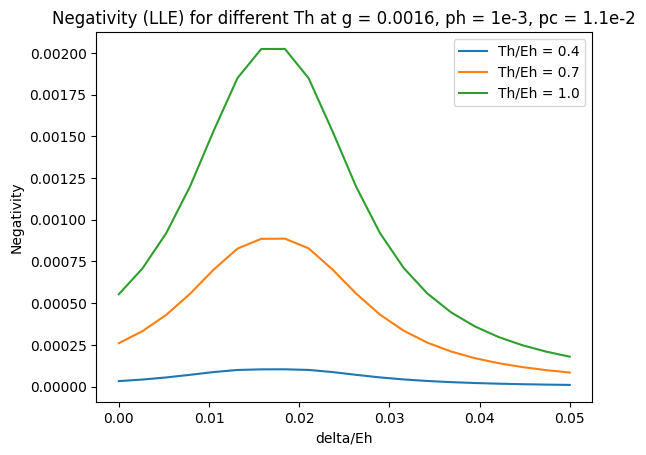

In [5]:
negativity_plot(Th_list,elist,redfield_ss)

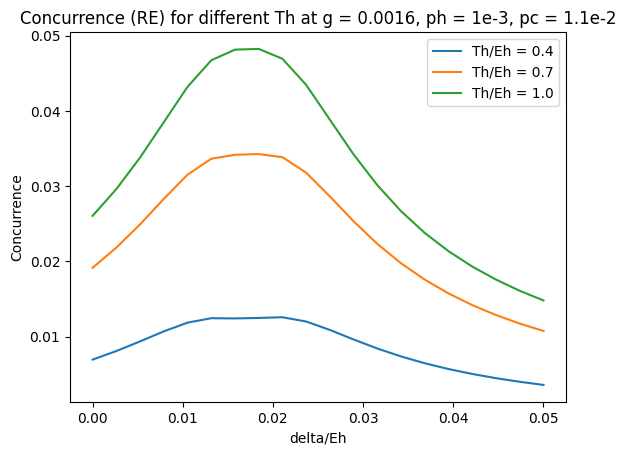

In [6]:
concurrence_plot(Th_list,elist,redfield_ss)

In [7]:
def thermal_h(E,T_h):
    r_c = 1/(1+np.exp(-E/T_h))
    t_h = r_c*fock_dm(2,1) + (1-r_c)*fock_dm(2,0)

    return t_h

def heat_current(Th_list,elist,reduced_dm_list):
    for i in range(len(Th_list)):
        heat_curr_list = []
        for j in range(len(elist)):
            ss = reduced_dm_list[i][j]
            rho_h = ss.ptrace(0)
            thermal_cold = thermal_h(1.0,Th_list[i])

            heat_curr = -gamma1*(fock(2,0).dag()*(rho_h - thermal_cold)*fock(2,0))  #as |0> is the excited state

            heat_curr_list.append(heat_curr.real)
        plt.plot(elist,heat_curr_list,label='Th/Eh = '+str(Th_list[i]))
    
    plt.xlabel('delta/Eh')
    plt.ylabel('Heat current')
    plt.title(f'Heat current (RE) for different Th at g = {g}, ph = 1e-3, pc = 1.1e-2')
    plt.legend()

    plt.show()

   

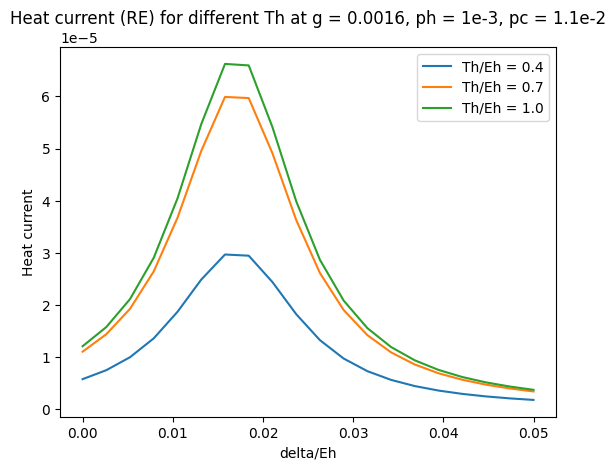

In [8]:
heat_current(Th_list,elist,redfield_ss)

In [9]:
def dissipator(op,rho):
    return op*rho*op.dag() - 0.5*op.dag()*op*rho - 0.5*rho*op.dag()*op

In [10]:
def heat_current_h(rho,beta2,e):
    gammah_plus =  gamma1*nbar(1,beta2,mu)
    gammah_minus = gamma1*(nbar(1,beta2,mu)+1)

    op1 = create_sm(N,1).dag()

    op_com = gammah_plus*dissipator(op1,rho) + gammah_minus*dissipator(op1.dag(),rho)
    H_S=create_hamiltonian2([1,1+e],[g,g],N)

    return (H_S*op_com).tr()

def heat_current_c(rho,beta2,e):
    gammac_plus = gamma2*nbar(1+e,beta1,mu)  #beta1 is fixed at 1/0.1
    gammac_minus = gamma2*(nbar(1+e,beta1,mu)+1)

    op2 = create_sm(N,N).dag()

    op_com = gammac_plus*dissipator(op2,rho) + gammac_minus*dissipator(op2.dag(),rho)
    H_S=create_hamiltonian2([1,1+e],[g,g],N)

    return (H_S*op_com).tr()

In [11]:
def heat_current_plot(Th_list,elist,lle_ss):
    for i in range(len(Th_list)):
        current_list = []
        for j in range(len(elist)):
            current_list.append(heat_current_h(lle_ss[i][j],betalist2[i],elist[j]) - heat_current_c(lle_ss[i][j],betalist2[i],elist[j]))
        plt.plot(elist,current_list,label='Th/Eh = '+str(Th_list[i]))

    plt.xlabel('delta/Eh')
    plt.ylabel('Heat current')
    plt.title(f'Heat current (LLE) for different Th at g = {g}, ph = 1e-3, pc = 1.1e-2')
    plt.legend()

    plt.show()

d:\Anaconda\envs\qiskitenv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\Anaconda\envs\qiskitenv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


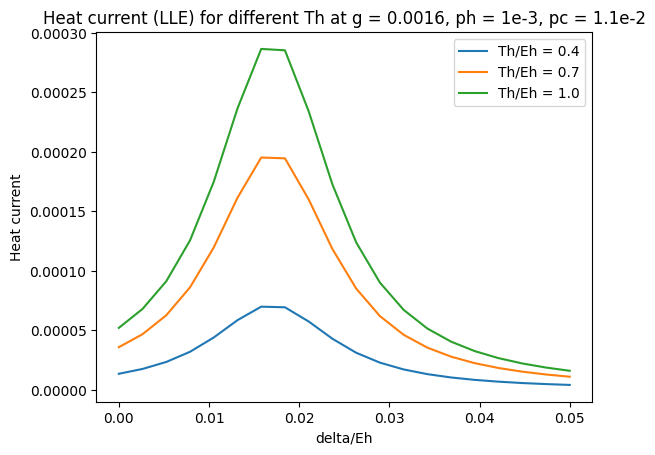

In [12]:
heat_current_plot(Th_list,elist,redfield_ss)